In [1]:
import matplotlib.pyplot as plt

In [2]:
class Code:
    def __init__(self, gcode):
        self.gcode = gcode
        self.G = None
        self.F = None
        self.X = None
        self.Y = None
        self.splitter()
        
        
    def splitter(self):
        if ';' in self.gcode:
            return
        c1 = self.gcode.split(' ')
        g = [i for i in c1 if 'G' in i]
        f = [float(i.strip('F')) for i in c1 if 'F' in i]
        x = [float(i.strip('X')) for i in c1 if 'X' in i]
        y = [float(i.strip('Y')) for i in c1 if 'Y' in i]
        
        if len(g) > 0:
            self.G = g[0]
        if len(f) > 0:
            self.F = f[0]
        if len(x) > 0:
            self.X = x[0]
        if len(y) > 0:
            self.Y = y[0]

In [9]:
class unSlicer2D:
    def __init__(self, file):
        '''
        the x and y argument are the size of the laser bed in mm
        the buffer is the relative distance between each layer, treated as a rectange of size (x max - min) by (y max - min)
        this will not optimize the size needed to cut all layers, but will lay them all out into a cuttable configuration. 
        '''
        
        with open(file) as c:
            self.code = c.readlines()
        self.file = file
        self.code = [i.split(' E0')[0].split(' Z')[0] for i in self.code] # remove unneeded info
        self.num = [int(i.split(':')[-1].strip('\n')) for i in self.code if ";LAYER_COUNT:" in i][0]
        self.ranges = [self.code.index(';LAYER:{}\n'.format(i)) for i in range(self.num)]
        self.ranges.append(-1)
        self.layers = {i:Layer(self.code[self.ranges[i]:self.ranges[i+1]]) for i in range(self.num)} # Split the layers into separate instances
        self.pages = 1
        
        
    def shifter(self, layer, dx=0, dy=0):
        for line in layer.lines.values():
            try:
                line.X += dx
                line.Y += dy
            except:
                pass
            layer()
    
    
    def Optimize(self, max_x=304, max_y=304, buffer=0):
        # step 1: move all layers to the origin
        for num in range(self.num):
            self.shifter(self.layers[num],dx=-self.layers[num].miX, dy=-self.layers[num].miY)
                
        # step 2: move one by one to fit grid 
        
        # move 0th layer first
        self.shifter(self.layers[0],dx=buffer, dy=buffer)
        
        x = self.layers[0].maX+buffer
        y = buffer
        my = self.layers[0].maY
        page = 0 # if there are more things than fit on one page
        
        for num in range(1,self.num):            
            if x + self.layers[num].maX + buffer >= max_x:
                x = buffer
                y = my + buffer
                my = 0
                
            else:
                x = self.layers[num-1].maX+buffer
            
            if y + self.layers[num].maY + buffer >= max_y:
                page += 1
                y = buffer
                x = buffer
                  
            self.shifter(self.layers[num],dx=x, dy=y)
            
            self.layers[num].page = page
        
            x = self.layers[num].maX+buffer
            
            if self.layers[num].maY > my:
                my = self.layers[num].maY
                
        self.pages = page + 1
        
        
    def Visualizer(self, save=False):
        for pg in range(self.pages):
            plt.figure(figsize=(5,5))
            plt.ylim(0,304)
            plt.xlim(0,304)
            plt.xlabel('x (mm)')
            plt.ylabel('y (mm)')
            for num in range(self.num):
                if self.layers[num].page == pg:
                    x = [i.X for i in self.layers[num].lines.values()]# if i.G == 'G1']
                    y = [i.Y for i in self.layers[num].lines.values()]# if i.G == 'G1']
                    plt.plot(x,y)
            plt.title(f'{self.file} - page {pg+1}')
            if save:
                plt.savefig('pyplot.png')
            plt.show()
            
            
    def Generate(self, file='test.gcode', passes=1, F=1000, S=1000):
        for pg in range(self.pages):
            f = open('{}_{}'.format(pg,file),'w')

            f.write('; Mount Zirkel Design G-Code Generator\n')
            f.write('; {}\n'.format(file))
            f.write('; file {} of {}\n\n'.format(pg+1, self.pages))
            f.write('S{}M3M8F{}\n'.format(S,F))
            f.write('\n')
            for p in range(passes):
                for layer in self.layers.values():
                    if layer.page == pg:
                        for line in layer.lines.values():
                            flag = False
                            if line.G is not None:
                                f.write(f'{line.G} ')
                                flag = True
                            if line.X is not None:
                                f.write(f'X{line.X} ')
                                flag = True
                            if line.Y is not None:
                                f.write(f'Y{line.Y}')
                                flag = True
                            if flag:
                                f.write('\n')
            f.write('\n; shut down laser, turn off fans\n')
            f.write('S0M5M9\n')
            f.write('; end of file')
            f.close()
        
class Layer:
    def __init__(self, gcode):
        self.gcode = gcode
        self.lines = {num : Code(line) for num,line in enumerate(self.gcode)}
        self.page = 0
        self()
        
    def __call__(self):
        self.maX = max([x.X for x in self.lines.values() if x.X is not None])
        self.miX = min([x.X for x in self.lines.values() if x.X is not None])
        self.maY = max([y.Y for y in self.lines.values() if y.Y is not None])
        self.miY = min([y.Y for y in self.lines.values() if y.Y is not None])
        
            

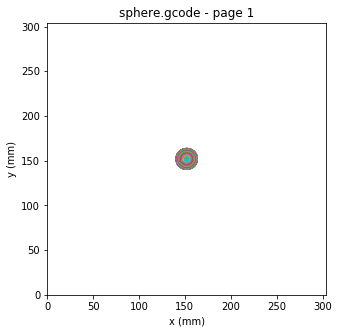

In [10]:
l2 = unSlicer2D('sphere.gcode')
l2.Visualizer(save=False)

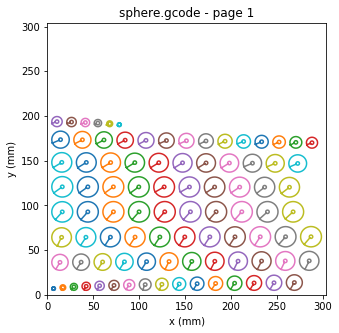

In [11]:
l2.Optimize(buffer=5)
l2.Visualizer(save=True)

In [12]:
l2.Generate(passes=3, file='laser_sphere.gcode')